In [1]:
if 'already_executed' not in globals():
    already_executed = False

if not already_executed:
    import os
    os.chdir("../")
    %load_ext autoreload
    %autoreload 2
    already_executed = True

In [2]:
from copy import deepcopy
import numpy as np
from typing import Optional
from sklearn.preprocessing import StandardScaler
from src.pricers.abstract_pricer import PricerAbstract
from src.samplers.abstract_sampler import SamplerAbstract


import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [47]:
from src.samplers.geometric_brownian_motion_put_sampler import GeometricBrownianMotionPutSampler
sampler = GeometricBrownianMotionPutSampler(**{
    "asset0": 100.0,
    "sigma": 0.2,
    "r": 0.05,
    "strike": 100.0,
    "t": 1.0,
    "cnt_times": 365,
    "seed": None, 
    "cnt_trajectories": 10_00_000
})

In [4]:
from dataclasses import dataclass
@dataclass 
class A:
    _: int

self = A(0)

def _create_features(self, markov_state: np.ndarray, time_grid: np.ndarray) -> np.ndarray:
    n_paths, n_times, state_dim = markov_state.shape
    T = time_grid[-1]
    
    # Нормализованное время до экспирации
    time_to_exp = (T - time_grid) / T
    time_to_exp = np.tile(time_to_exp, (n_paths, 1))[..., None]
    
    # Объединяем время и состояние
    features = np.concatenate([time_to_exp, markov_state], axis=-1)
    flat_features = features.reshape(-1, features.shape[-1])
    
    # Первый вызов - инициализируем и фитим трансформеры
    if not self.is_fitted_:
        self.scaler_ = StandardScaler()
        self.poly_ = PolynomialFeatures(degree=self.degree, include_bias=True)
        
        scaled = self.scaler_.fit_transform(flat_features)
        poly_features = self.poly_.fit_transform(scaled)
        self.n_features_ = poly_features.shape[1]
        self.is_fitted_ = True
    else:
        # Используем обученные трансформеры
        scaled = self.scaler_.transform(flat_features)
        poly_features = self.poly_.transform(scaled)
    
    return poly_features.reshape(n_paths, n_times, -1)

def _create_features(self, markov_state: np.ndarray, time_grid: np.ndarray) -> np.ndarray:
    M = markov_state[:, :, 0] / 100.
    exp_term = np.exp(-M / 2.0)
    T = time_grid[-1]
    t = time_grid

    phi = np.zeros((*markov_state[:, :, 0].shape, 7), dtype = float)
    phi[:, :, 0] = 1.0
    phi[:, :, 1] = exp_term
    phi[:, :, 2] = exp_term * (1.0 - M)
    phi[:, :, 3] = exp_term * (1.0 - 2.0 * M + 0.5 * M * M)
    phi[:, :, 4] = np.sin(np.pi * (T - t) / (2.0 * T))
    phi[:, :, 5] = np.log(np.maximum(T - t, 1e-10)) # 1e-10 чтобы не было log(0)
    phi[:, :, 6] = (t / T) ** 2

    scaler = StandardScaler()
    phi_reshaped = phi[:, :, 1:].reshape(-1, 6)
    phi_scaled = scaler.fit_transform(phi_reshaped)
    phi_scaled = phi_scaled.reshape(phi.shape[0], phi.shape[1], 6)


    phi_final = np.zeros_like(phi)
    phi_final[:, :, 0] = phi[:, :, 0]
    phi_final[:, :, 1:] = phi_scaled

    return phi_final

In [5]:
self.sampler = sampler
self.sampler.sample()

GBM sampling:   0%|          | 0/364 [00:00<?, ?it/s]

In [6]:
r = -np.log(self.sampler.discount_factor[0, 1] / self.sampler.discount_factor[0, 0]) / (self.sampler.time_deltas[0])
self.dt = sampler.time_deltas[0]
self.is_fitted_ = False
self.degree = 3
self.iterations = 100
self.tol = 1e-6
quiet = False

In [7]:
# Параметры
n_paths, n_times, _ = self.sampler.markov_state.shape
gamma = np.exp(-r * self.dt)  # Коэффициент дисконтирования

# Создаем признаки
phi_all = _create_features(self,
    self.sampler.markov_state, 
    self.sampler.time_grid
)
n_features = phi_all.shape[-1]


w = np.zeros(n_features)

# Подготовка данных
phi_curr = phi_all[:, :-1, :]  # Текущие состояния (t)
phi_next = phi_all[:, 1:, :]    # Следующие состояния (t+1)
payoff_next = self.sampler.payoff[:, 1:]  # Выплаты в t+1

# Выравнивание в 1D
phi_curr_flat = phi_curr.reshape(-1, n_features)
phi_next_flat = phi_next.reshape(-1, n_features)
payoff_next_flat = payoff_next.reshape(-1)

# Флаг нетерминальных состояний
non_terminal = np.tile(np.arange(n_times-1) < n_times-2, (n_paths, 1))
non_terminal_flat = non_terminal.reshape(-1)

# Итерации LSPI
for it in tqdm(range(self.iterations), desc="LSPI iterations"):
    prev_w = deepcopy(w)
    
    # Вычисляем Q-значения продолжения
    Q_cont_next = phi_next_flat @ w
    
    # Условие продолжения
    continue_cond = non_terminal_flat & (Q_cont_next >= payoff_next_flat)
    
    # Формируем систему уравнений
    diff_phi = phi_curr_flat - gamma * continue_cond[:, None] * phi_next_flat
    A = phi_curr_flat.T @ diff_phi
    b = gamma * phi_curr_flat.T @ ((~continue_cond) * payoff_next_flat)
    
    w = np.linalg.solve(A, b)
    
    # Проверка сходимости
    diff_norm = np.linalg.norm(w - prev_w)
    if not quiet:
        print(f"Iteration {it}: ||Δw|| = {diff_norm:.9f}")
    if diff_norm < self.tol:
        if not quiet:
            print(f"Converged after {it} iterations")
        break

self.w = w


LSPI iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0: ||Δw|| = 1035.932678046
Iteration 1: ||Δw|| = 1851.543049148
Iteration 2: ||Δw|| = 162.867922919
Iteration 3: ||Δw|| = 165.328923173
Iteration 4: ||Δw|| = 132.606730096
Iteration 5: ||Δw|| = 55.621167512
Iteration 6: ||Δw|| = 17.349253082
Iteration 7: ||Δw|| = 26.464796962
Iteration 8: ||Δw|| = 18.530261051
Iteration 9: ||Δw|| = 2.617309018
Iteration 10: ||Δw|| = 0.045218081
Iteration 11: ||Δw|| = 0.000028073
Iteration 12: ||Δw|| = 0.000000000
Converged after 12 iterations


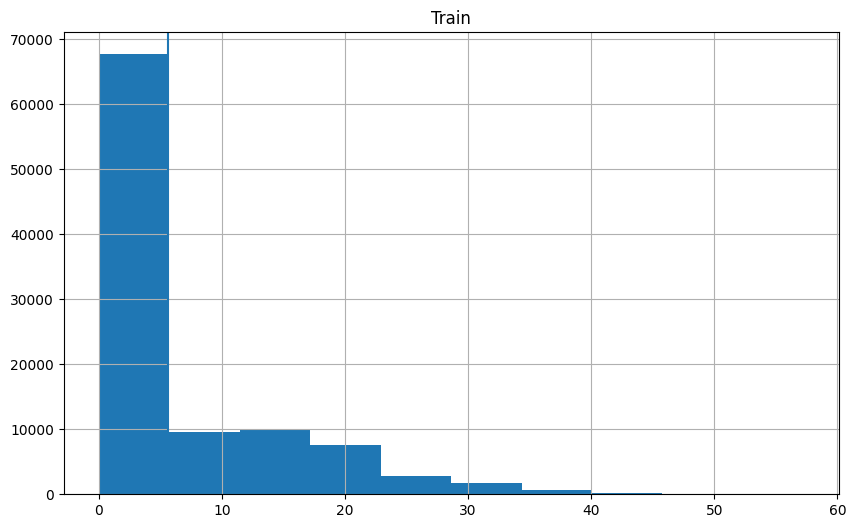

np.float64(5.5975329849255395)

In [8]:
pv_payoffs = np.zeros(n_paths)
for p in range(n_paths):
    for t in range(n_times):
        # Признаки текущего состояния
        phi_t = phi_all[p, t]
        Q_cont = phi_t @ w
        payoff_t = self.sampler.payoff[p, t]
        
        # Условие исполнения
        if payoff_t >= Q_cont or t == n_times - 1:
            disc_factor = self.sampler.discount_factor[p, t]
            pv_payoffs[p] = disc_factor * payoff_t
            break
mean = pv_payoffs.mean()

plt.figure(figsize=(10, 6))
plt.hist(pv_payoffs)
plt.axvline(mean)
plt.title("Train")
plt.grid()
plt.show()
mean

In [9]:
self.sampler.sample()

GBM sampling:   0%|          | 0/364 [00:00<?, ?it/s]

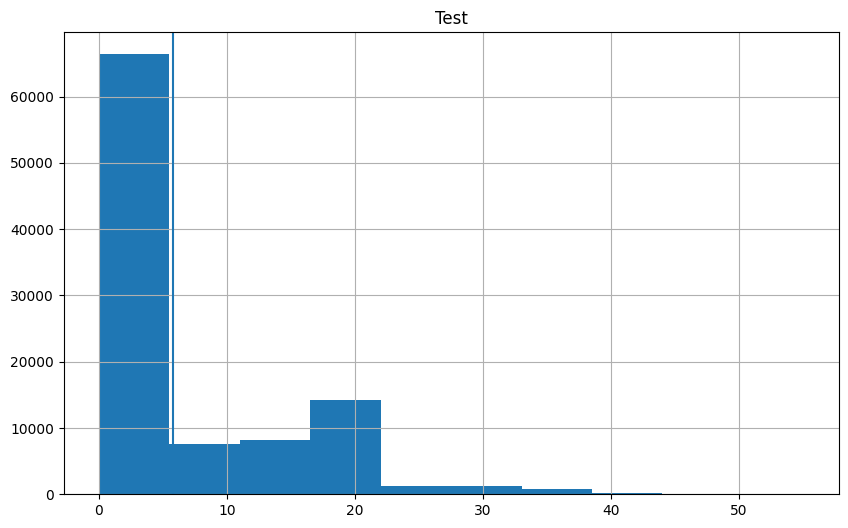

np.float64(5.766552066351486)

In [10]:
phi_all = _create_features(self,
    self.sampler.markov_state, 
    self.sampler.time_grid
)
pv_payoffs = np.zeros(n_paths)
for p in range(n_paths):
    for t in range(n_times):
        # Признаки текущего состояния
        phi_t = phi_all[p, t]
        Q_cont = phi_t @ w
        payoff_t = self.sampler.payoff[p, t]
        
        # Условие исполнения
        if payoff_t >= Q_cont or t == n_times - 1:
            disc_factor = self.sampler.discount_factor[p, t]
            pv_payoffs[p] = disc_factor * payoff_t
            break
mean = pv_payoffs.mean()

plt.figure(figsize=(10, 6))
plt.hist(pv_payoffs)
plt.axvline(mean)
plt.title("Test")
plt.grid()
plt.show()
mean

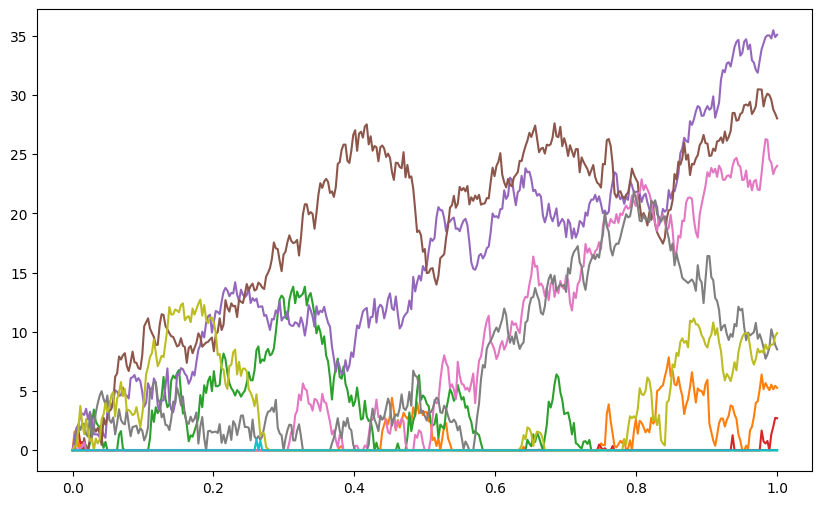

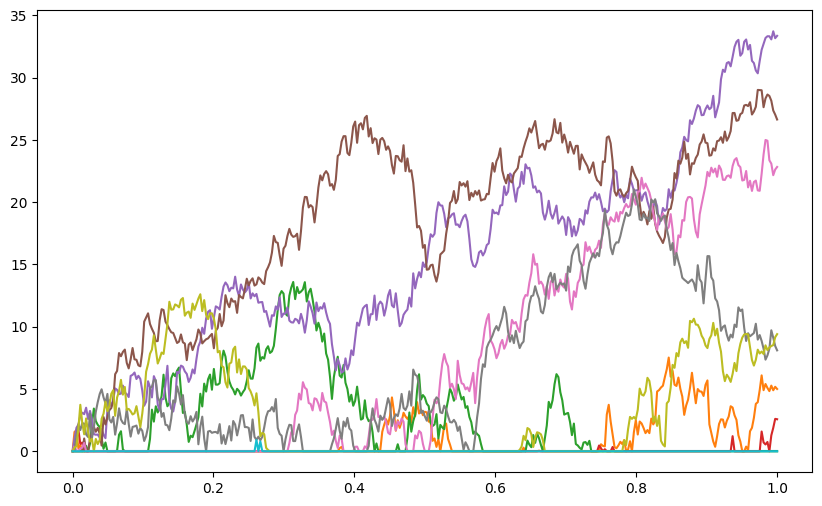

In [11]:
n_traj = 10

plt.figure(figsize=(10, 6))
plt.plot(self.sampler.time_grid, self.sampler.payoff[:n_traj, :].T)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(self.sampler.time_grid, (self.sampler.payoff[:, :] * self.sampler.discount_factor)[:n_traj, :].T)
plt.show()

# LSMC

AMC price train: 100%|#########9| 363/364 [01:12<00:00,  4.44it/s]

/home/jovyan/vorobiov/AmericanOptionsPricingApproaches/src/pricers/american_monte_carlo.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


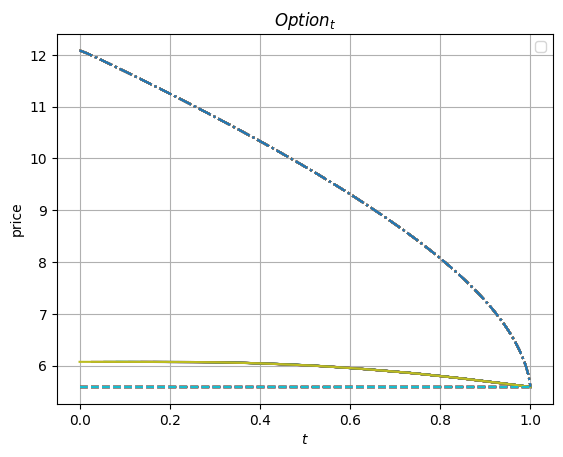

In [48]:
from src.pricers.american_monte_carlo import AmericanMonteCarloPricer
pricer = AmericanMonteCarloPricer(sampler, degree=2)
pricer.price();

  0%|          | 0/365 [00:00<?, ?it/s]

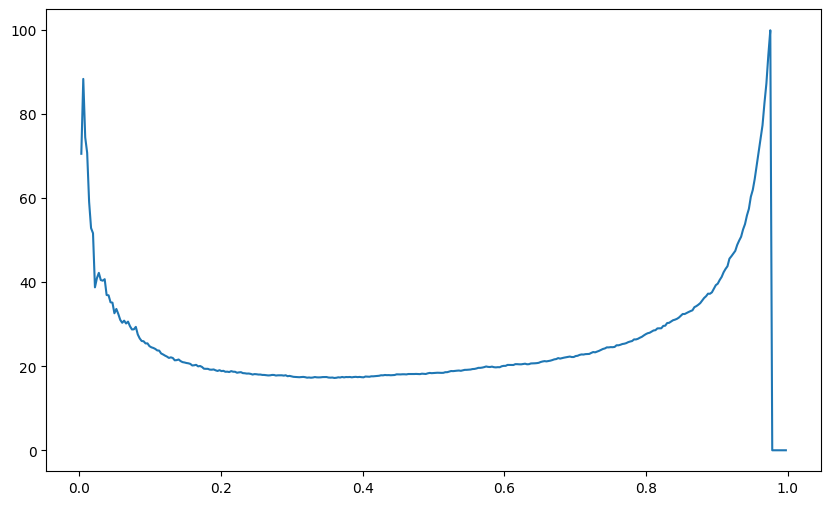

In [51]:
import scipy
exercise_boundary_lsmc = []
for i, t in tqdm(list(enumerate(range(len(sampler.time_grid))))):
    if pricer.weights[i] is None:
        exercise_boundary_lsmc.append(None)
        continue
    exercise_boundary_lsmc.append(
        scipy.optimize.minimize_scalar(
            lambda x: (
                sampler.discount_factor[0, i] * max(0, 100. - x) - 
                (
                    pricer.basis_functions_transformer.transform([[x]]) @ pricer.weights[i]
                ).reshape(-1)[0]
            )**2,
            bounds=[0, 100]
        )["x"]
    )

plt.figure(figsize=(10, 6))
plt.plot(sampler.time_grid, exercise_boundary_lsmc)
plt.show()

In [ ]:
import scipy
exercise_boundary_lsmc = []
for i, t in tqdm(list(enumerate(range(len(sampler.time_grid))))):
    if pricer.weights[i] is None:
        exercise_boundary_lsmc.append(None)
        continue
    exercise_boundary_lsmc.append(
        scipy.optimize.minimize_scalar(
            lambda x: (
                sampler.discount_factor[0, i] * max(0, 100. - x) - 
                (
                    pricer.basis_functions_transformer.transform([[x]]) @ pricer.weights[i]
                ).reshape(-1)[0]
            )**2,
            bounds=[0, 100]
        )["x"]
    )

plt.figure(figsize=(10, 6))
plt.plot(sampler.time_grid, exercise_boundary_lsmc)
plt.show()

In [49]:
pricer.weights # почему в конце None

[None,
 array([ 6.41080074, -0.25016612,  0.00815643]),
 array([ 6.54789924e+00, -3.92305724e-01,  5.08024010e-03]),
 array([ 6.65315503, -0.48079655,  0.0098479 ]),
 array([ 6.74791805, -0.56348747,  0.01242452]),
 array([ 6.82903602, -0.62764831,  0.02032046]),
 array([ 6.89156295, -0.68967528,  0.02738318]),
 array([ 6.95937782, -0.75697438,  0.03011269]),
 array([ 7.0058797 , -0.78407766,  0.05618101]),
 array([ 7.06918785, -0.85576939,  0.05182659]),
 array([ 7.12952024, -0.91452259,  0.04998622]),
 array([ 7.18333119, -0.95862606,  0.05543113]),
 array([ 7.23502755, -1.00231424,  0.0568812 ]),
 array([ 7.28271439, -1.05484626,  0.0571631 ]),
 array([ 7.31795621, -1.09015887,  0.07017253]),
 array([ 7.36122434, -1.14165453,  0.0717924 ]),
 array([ 7.40275959, -1.16734   ,  0.07917517]),
 array([ 7.44305059, -1.21297651,  0.08088835]),
 array([ 7.48045161, -1.23868335,  0.09409036]),
 array([ 7.51963523, -1.28897047,  0.09010731]),
 array([ 7.55266754, -1.32104945,  0.09752497]),
 